Build logistic regression model and random forest model to predict whether a patient dies after admitted into ICU.

ICD9 diagnosis:
3961	Extracorporeal circulat
3891	Arterial catheterization	
3893	Venous cath NEC	
8856	Coronar arteriogr-2 cath	
9604	Insert endotracheal tube	
966	    Entral infus nutrit sub	
9671	Cont inv mec ven <96 hrs	
9672	Cont inv mec ven 96+ hrs	
9904	Packed cell transfusion	
9955	Vaccination NEC

Lab items:
ITEMID	LABEL               FLUID	  CATEGORY	
50820	pH	     	        Blood     Blood Gas	
50868	Anion Gap	        Blood	  Chemistry	
50882	Bicarbonate	        Blood	  Chemistry	
50902	Chloride	        Blood	  Chemistry	
50912	Creatinine	        Blood	  Chemistry	
50931	Glucose	            Blood	  Chemistry	
50960	Magnesium	        Blood	  Chemistry	
50970	Phosphate	        Blood	  Chemistry	
50971	Potassium	        Blood	  Chemistry	
50983	Sodium	            Blood	  Chemistry	
51006	Urea Nitrogen       Blood	  Chemistry	
51221	Hematocrit	        Blood	  Hematology	
51222	Hemoglobin	        Blood	  Hematology	
51248	MCH	                Blood	  Hematology	
51249	MCHC	            Blood	  Hematology	
51250	MCV	                Blood	  Hematology	
51265	Platelet Count	    Blood	  Hematology	
51277	RDW         	    Blood	  Hematology	
51279	Red Blood Cells	    Blood	  Hematology	
51301	White Blood Cells	Blood	  Hematology	

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from numpy import mean
from numpy import std
from pprint import pprint

In [2]:
df = pd.read_csv('MIMIC_cleaned.csv')

In [3]:
#replece NA with 0
df.fillna(0, inplace=True)

In [4]:
cols = ['ETHNICITY','GENDER','MULTI_ENTRY_ICU','ICD9_9955',
       'ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672', 'ICD9_9904',
       'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891', 'HOSPITAL_EXPIRE_FLAG']
for col in cols:
    df[col] = df[col].astype("category").cat.codes

### train and test data

In [5]:
y = df['HOSPITAL_EXPIRE_FLAG']

In [6]:
X = df[['ETHNICITY','GENDER', 'AGE_ON_AD', 'ICU_STAY_DAYS', 'MULTI_ENTRY_ICU', 'ICD9_9955',
       'ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672', 'ICD9_9904',
       'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',  'PROP_ITEMID_51221', 'PROP_ITEMID_51222',
       'PROP_ITEMID_51248', 'PROP_ITEMID_51249', 'PROP_ITEMID_51250',
       'PROP_ITEMID_51265', 'PROP_ITEMID_51277', 'PROP_ITEMID_51279',
       'PROP_ITEMID_51301', 'PROP_ITEMID_50820', 'PROP_ITEMID_50868',
       'PROP_ITEMID_50882', 'PROP_ITEMID_50902', 'PROP_ITEMID_50912',
       'PROP_ITEMID_50931', 'PROP_ITEMID_50960', 'PROP_ITEMID_50970',
       'PROP_ITEMID_50971', 'PROP_ITEMID_50983', 'PROP_ITEMID_51006']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
 test_size=1/5.0, random_state=0)

### Logistic regression

In [8]:
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)

In [9]:
predictions = logisticRegr.predict(X_test)

In [10]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.921244489657511


In [11]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)

Text(0.5, 257.44, 'Predicted label')

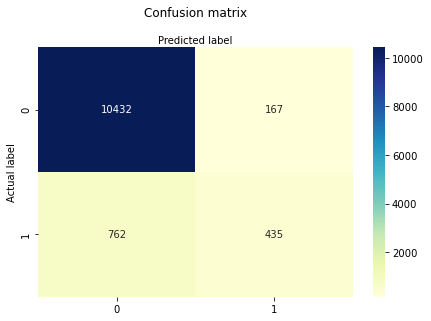

In [12]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [13]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

Accuracy: 0.921244489657511
Precision: 0.7225913621262459
Recall: 0.3634085213032581


### Random forest hyperparameter tuning

In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30,90, num = 3)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [30, 60, 90, None],
 'n_estimators': [200, 400, 600]}


In [15]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
randomforest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = randomforest, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 12 is smaller than n_iter=1000. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.8min finished


{'n_estimators': 400, 'max_depth': 30, 'bootstrap': True}

In [22]:
#Random forest model n_estimator=600
randomforest = RandomForestClassifier(n_estimators=400,max_depth=None, bootstrap=True,random_state=42)
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)

In [23]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 225.76, 'Predicted label')

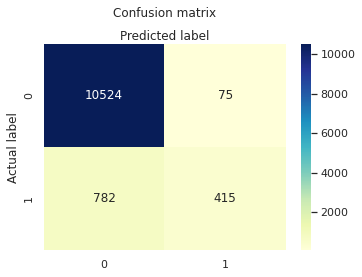

In [24]:
sns.set(rc={'figure.figsize':(5,3.5)})
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [25]:
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     10599
           1       0.85      0.35      0.49      1197

    accuracy                           0.93     11796
   macro avg       0.89      0.67      0.73     11796
weighted avg       0.92      0.93      0.91     11796

0.9273482536453035


In [26]:
feature_imp = pd.Series(randomforest.feature_importances_,index=X.columns).sort_values(ascending=False)

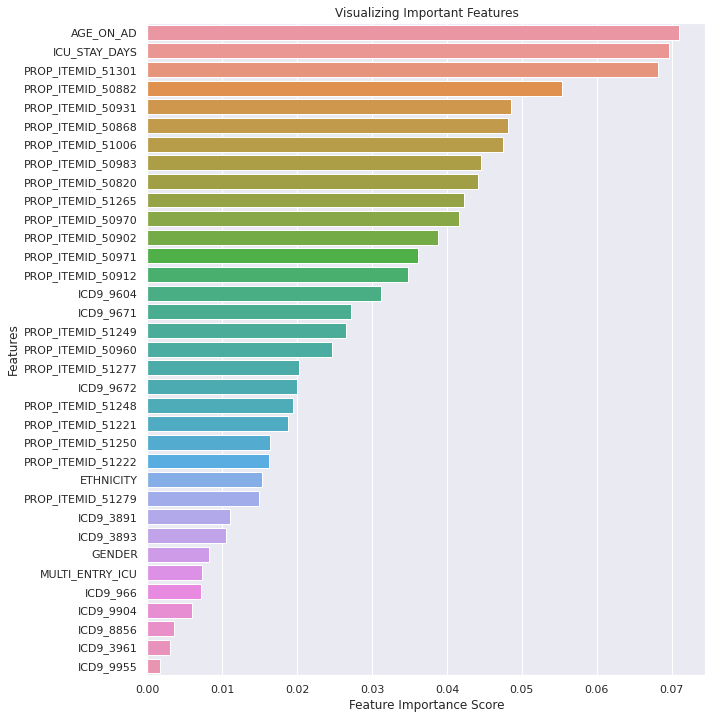

In [27]:
sns.set(rc={'figure.figsize':(10,12)})
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()